## TODO

References

TODO: simultaneous requests for speedup

WTF is it going SO slowly?????

Tidy up

Convert into proper blog post

# Hotdog / not hotdog


>_What would you say if I told you there is a app on the market that tell you if you have a hotdog or not a hotdog. It is very good and I do not want to work on it any more. You can hire someone else._
>
>Jian-Yang, 2017

I have been looking to get into Deep Learning for a while now. It's been a hugely hot topic for years now, and the libraries seem to be maturing fast. However, most initial tutorials I've found seem a little... boring. I mean, it's great to be able to recognize digits or tell cats from dogs, but what if I could [tell hotdogs from not hotdogs]? Maybe I'd package that into [iOS] and [Android] apps. And I could sell to Periscope and [become really rich, not like that conman Bachmann]!!

So I embarked on just that journey: to build the best hotdog/no hotdog classifier a Data Scientist with no prior experience in Deep Learning can build. Join me in this series of posts if you want to do the same!

[tell hotdogs from not hotdogs]: https://www.youtube.com/watch?v=ACmydtFDTGs
[become really rich, not like that conman Bachmann]: https://www.youtube.com/watch?v=AJsOA4Zl6Io
[iOS]: https://itunes.apple.com/us/app/not-hotdog/id1212457521?mt=8
[Android]: https://play.google.com/store/apps/details?id=com.seefoodtechnologies.nothotdog&hl=en

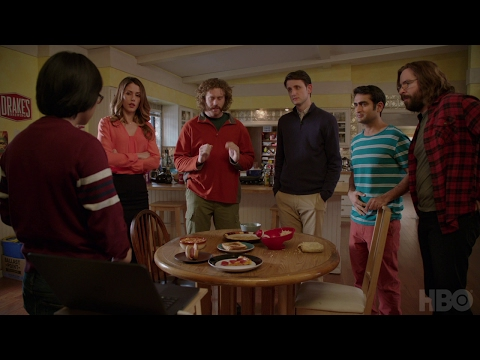

In [3]:
from IPython.display import YouTubeVideo

YouTubeVideo('ACmydtFDTGs')

# AI, Machine Learning, Deep Learning

Since you are reading this blog post, you probably are someone with a technical background in the Data Science sphere. If you already know this, bear with me because I'm going to frame the discussion a bit just so we are in the same page. You can also skip to the next section.

Artificial Intelligence, AI, is a very poorly defined term. The best definition I've got so far is 'the science of teaching computers to think like humans'[citation needed](). It also seems to be an ever receding horizon: as soon as some cognitive task (addition, looking up references, recognizing digits, translation..) is performed by machines routinely, it stops being AI because it isn't the exclusive province of humans anymore. So it doesn't seem very useful.

Machine Learning, ML, can be considered a subset of AI. It's just a set of algorithms that allow computers to learn rules from data. You get some tagged examples, give them to the algorithm, and voila, you have a digit recognizer, or a churn predictor, or whatever else you want (that's actually supervised machine learning, but let's not get into that).

Finally, Deep Learning (DL), which is what most general publications are talking about these days when they talk about AI. It's a subset of ML. It uses Neural Networks, or multilayer perceptrons. These are just mathematical machines that can approximate any function, for example one that eats images of digits (matrices of 28x28 pixels) and spits out one of ten values indicating which of the digits it is. 

So, if it's just that, how come it's eating the world? Well, a number of trends have coalesced to push DL into extraordinary results. Some algorithmic advances, the unprecedented availability of data brought by the move of everyday life to the Internet and advances in computer power (especially, training of neural networks on GPUs) have enabled DL to outperform traditional approaches in a lot of fields: especially image classification, but also image segmentation, translation, sentiment analysis, recommendations and a lot more. The hope is that many more tasks that until now were the exclusive of humans can be automated in the near future (remember that receding horizon?), including driving a car. That last one has been overhyped in my opinion, but the power and applicability of the technique is undeniable.

![The contest that started it](https://blogs.nvidia.com/wp-content/uploads/2016/06/DefenseAIPicture3-002.png)

The current frenzy probably started with the [ImageNet] competition of 2012. ImageNet was a [competition] held every year in which academic teams would compete to write the algorithm that would recognize the most images from a huge standardized set. In 2012, two teams entered the competition using DL techniques and bested everyone else. As you can see in the graph, it didn't take long before everyone was using it to get unprecented results. Now it's everywhere, and we are finally going to be part of the action. 

[ImageNet]: http://image-net.org
[competition]: http://www.image-net.org/challenges/LSVRC/

# This project

So let's recapitulate: we are going to build a computer program that, after being shown enough examples of hot dogs and things that are not hotdogs, will learn to tell between them. 

For that, we need:

- Training images
- A Deep Learning Framework
- A computer with a GPU

Today, we'll deal with the images. It's going to be a bit long, but it'll be worth it. At the end we'll have what we need for building our revolutionary hotdog/nohotdog app. Not only that; we'll have a method that will be applicable for getting training images for any classifier in the ImageNet vocabulary.

# ImageNet

We need a set of images that are NOT hotdogs in order to be able to train our algorithm. For that we can use the ImageNet set of tagged images. The thing is, ImageNet contains more than a million images totalling around 100GB. Not only would that take a long time to download: it would be prohibitively costly to train. We are going to download only a part of it for now.

For that, we need to understand how ImageNet is structured. It is based upon [WordNet], a lexical database of English. WordNet contains nouns, verbs, adjectives and adverbs grouped into _synsets_ (sets of synonyms), but ImageNet contains images corresponding only to the nouns. Each synset is identified by its wnid (WordNet id). There are actually three hotdog synsets: n07676602, n07697537, and n10187710.

ImageNet doesn't own the images, so they only provide them after a registration and a request promising to use them for non-commercial research and/or educational use. However, they do provide the image urls freely, so we are going to use our downloader to get them. We will need to get the urls first.

[WordNet]: https://wordnet.princeton.edu/

In [ ]:
import requests
import os

def download(url):
    '''
    Download a single freely available file if it's not already in the current directory.
    '''
    filename = url.split('/')[-1]

    # Do not re-download: the damn website is sloooooow 
    if not os.path.exists(filename):
    
        # Download and write to file
        response = requests.get(wnids_url)   
        with open(filename, 'wb') as f: 
            f.write(response.content)

In [8]:
%%time

# Retrieve the list of terms from the imagenet website:
download('http://image-net.org/archive/words.txt')
    
# Build a dictionary of wnids and terms: as easy as one dict comprehension
with open('words.txt') as f:
    wnids = {line.split()[0]: line.split()[1] for line in f.readlines()}

CPU times: user 88 ms, sys: 11.6 ms, total: 99.6 ms
Wall time: 96.3 ms


wnids are overlapping, that is, there are general terms and more specific terms that are contained within them (hyponyms). The easiest way to deal with this is to just get the urls for the images we want and deduplicate them. 

We need two things: A list of all the image urls and a list of all hotdog urls. The ImageNet website has an api for retrieving the urls that correspond to a wnid, so we'll use that.

In [15]:
import matplotlib.pyplot as plt
from IPython.display import Image, display
%matplotlib inline

def urls_from_wnid(wnid):
    '''Get all image urls corresponding to a single WordNet (noun) ID'''
    response = requests.get('http://www.image-net.org/api/text/imagenet.synset.geturls', params={'wnid' : wnid})
    urls = response.content.decode('latin1').splitlines()
    
    return urls

first_five_images = [Image(url=url, width=400) for url in urls_from_wnid('n07697537')[:5]]

display(*first_five_images)

We see here a first problem: a lot of the links are broken. Don't worry, there are enough for our purposes.

This would work also to get all images, but it would extremely slow because we are making over 80000 requests. Also because the damn imagenet site is sloooooooow. What we are going to do is use this technique to get all hotdog urls and then substract those from the complete list of urls, which is freely available from the ImageNet website.

In [10]:
%%time

hotdog_wnids = {wnid for wnid, term in wnids.items() if 'hot' in term and 'dog' in term}
hotdog_urls = {url for wnid in hotdog_wnids for url in urls_from_wnid(wnid)} 

len(hotdog_urls)

CPU times: user 27.6 ms, sys: 12.2 ms, total: 39.8 ms
Wall time: 5min 33s


In [6]:
%%time

imagenet_fall11_urls = 'http://image-net.org/imagenet_data/urls/imagenet_fall11_urls.tgz'

download(imagenet_fall11_urls)

CPU times: user 657 µs, sys: 102 µs, total: 759 µs
Wall time: 889 µs


Now we need to build the list of all urls. We just read the file and fill the list.

In [32]:
%%time
import tarfile

tf = tarfile.open('imagenet_fall11_urls.tgz')

# Shortcut: I know it contains a single file, so we extract the first member.
content = tf.extractfile(tf.getmembers()[0])

wnid_urls = []
for line in content:
    try:
        # Split a single line at a tab
        wnid, url = line.decode('utf-8')[:-1].split('\t')
    except:
        # There are a few urls that fail; too few to worry
        # If you want to check them out, print(line)
        pass
        
    wnid_urls.append((wnid, url))


len(wnid_urls)

CPU times: user 29.2 s, sys: 1.73 s, total: 30.9 s
Wall time: 30.9 s


Aaaand we have it! Just need to dedup the urls and substract the hotdog urls.

In [35]:
# Some urls might be duplicated; dedup by using a set comprehension
# You can tell I really like comprehensions in python, can't you?
all_urls = {url for wnid, url in wnid_urls}

# We already have the hotdog urls from before> tidy up 
other_urls = all_urls - hotdog_urls

print((len(all_urls), len(hotdog_urls), len(other_urls)))

(13023003, 1216, 13021791)


In [44]:
import random
from sklearn.model_selection import train_test_split

random.seed(42)

hotdogs_sample = random.sample(hotdog_urls, 1216) # Use all of themfor now
nohotdogs_sample = random.sample(other_urls, k=10000) # Let's get as many as we can without overunbalancing the classes

hd_train, hd_val = train_test_split(hotdogs_sample, random_state=42)
nohd_train, nohd_val = train_test_split(nohotdogs_sample, random_state=42)

Let's write them down so we don't lose them, and we can use the lists from outside python:

In [45]:
with open('hotdogs_sample.txt', 'w') as f:
    f.write('\n'.join(hotdogs_sample))
    
with open('nohotdogs_sample.txt', 'w') as f:
    f.write('\n'.join(nohotdogs_sample))

### Notes


Last layer -> sigmoid (1 vs all classification)

How to calculate learning rates with Keras?? -> maybe another blog post

  * Somewhat related: what does Jeremy Howard refer to as each of the three parts of a net? and can you set differential learning rates in Keras??
  
[Image(url=url, width=400) for url in urls_from_wnid('n07697537')[:5]]

https://stackoverflow.com/questions/24398044/downloading-a-lot-of-files-using-python

### Further Reading

(revise before posting)

[imagenet-downloader](https://github.com/xkumiyu/imagenet-downloader/)

http://image-net.org/synset?wnid=n07697537

http://www.image-net.org/api/text/imagenet.synset.geturls?wnid=n07697537

http://caffe.berkeleyvision.org/gathered/examples/imagenet.html

# For a follow-up post: download the images from Python

In [41]:
base_dir = 'data'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

folders_urls = { os.path.join(train_dir, 'hotdog'): hd_train,
                 os.path.join(train_dir, 'nohotdog'): nohd_train,
                 os.path.join(validation_dir, 'hotdog'): hd_val,
                 os.path.join(validation_dir, 'nohotdog'): hd_val }

We should actually use a logging specific module, but let's keep things simple

In [ ]:
import imghdr
import shutil
from tqdm import tqdm
from datetime import datetime

log = open('log_img_download', 'w')
debug=False

for folder, urls in folders_urls.items():
    ok = 0
    fail = 0
    shutil.rmtree(folder, ignore_errors=True)
    os.makedirs(folder)
    
    log.write(f'{datetime.now()} Starting with {folder}\n')
    
    # tqdm is a very nice little module for progress reporting
    for image_url in tqdm(urls):
        try:
            # It is VERY important to set a timeout here! otherwise the program will stall
            # 
            response = requests.get(image_url)
            
            if response.status_code == 200 and imghdr.what(None, h=response.content) in ['jpeg', 'png']:
                filename = image_url.split('/')[-1].split('?')[0]
                
                f = open(os.path.join(folder, filename), 'wb')
                f.write(response.content)
                if debug: log.write(f'{datetime.now()} wrote {filename}\n')
                ok += 1
            else: 
                log.write(f'{datetime.now()} {response.status_code} response for {image_url} of type {imghdr.what(None, h=response.content)}\n')
                fail += 1
                
        except Exception as e:
            log.write(f'{datetime.now()} Something went wrong with image {image_url}: {e}\n')
                    
    log.write(f'{datetime.now()} Wrote {ok} images in folder {folder}, with {fail} failures\n')

log.close()    

 75%|███████▌  | 687/912 [30:38<10:01,  2.68s/it]

To do: either get all the images and subset, or keep retrying connections until I get the desired number of images. There are _a lot_ of broken links.

https://stackoverflow.com/questions/36554365/downloading-many-images-with-python-requests-and-multiprocessing